In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from toolz import valmap
import pprint

# get rid of warnings to make results less verbose
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('..')
import wismut.analyze_chains as ac
path = os.getcwd() + "/"

## Analysis settings
- $\beta = 0.3$ naive estimates without ME correction 5k miner
- $\beta = 0.6$ naive estimates without ME correction 5k miner
- $\beta = 0.3$ with ME correction 5k miner
- $\beta = 0.3$ with ME correction 5k miner
- $\beta = 0.3$ with ME correction 5k miner misspecification 1
- $\beta = 0.3$ with ME correction 5k miner misspecification 2


In [25]:
samples = dict(
    b3_naive = ac.load_traces_parameter("beta.txt", "../results/simulation_study/b3-5-naive/"),
    b6_naive = ac.load_traces_parameter("beta.txt", "../results/simulation_study/b6-5-naive/"),
    b3_corrected = ac.load_traces_parameter("beta.txt", "../results/simulation_study/b3-5/"),
    b6_corrected = ac.load_traces_parameter("beta.txt", "../results/simulation_study/b6-5/"),
    misspec1 = ac.load_traces_parameter("beta.txt", "../results/simulation_study/missspec1/"),
    misspec2 = ac.load_traces_parameter("beta.txt", "../results/simulation_study/missspec2/"),
)

In [26]:
res_reduced = valmap(lambda d: ac.reduce_results(d, (1,len(d)+1)), samples)

In [22]:
# ac.dict_map(lambda x: x.posterior.dims, samples)

In [23]:
x = np.arange(100)[:20]
means = [res_reduced["b3_naive"][i]["mean"] for i in res_reduced["b3_naive"]][:20]
median = [res_reduced["b3_naive"][i]["median"] for i in res_reduced["b3_naive"]][:20]
limits = [res_reduced["b3_naive"][i]["hdi"] for i in res_reduced["b3_naive"]][:20]
limits = [np.concatenate(limits)[::2], np.concatenate(limits)[1::2]]

In [6]:
def plot_simulation_results(reduced_results, true_value, axs=None,n_datasets=20, legend=False, title=None):
    x = np.arange(n_datasets)
    means = [reduced_results[i]["mean"] for i in reduced_results][:n_datasets]
    median = [reduced_results[i]["median"] for i in reduced_results][:n_datasets]
    limits = [reduced_results[i]["hdi"] for i in reduced_results][:n_datasets]
    limits = [np.concatenate(limits)[::2], np.concatenate(limits)[1::2]]

    axs.set_title(title) if axs is not None else plt.title("title")
    if axs is None:
        axs = plt
    axs.errorbar(x, means, yerr=limits, fmt='h', elinewidth=2.5, label=r"Poesterior $\beta$", color="darkblue", alpha=0.5)
    axs.hlines(true_value, 0, n_datasets-1, color="black", zorder=5, linestyle="dashed", linewidth=2, label="True mean")
    axs.hlines(np.mean(means), 0, n_datasets-1, color="orange", zorder=5, linestyle="dashed", linewidth=2, label="Mean estimated")
    axs.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False) # labels along the bottom edge are off
    if legend:
        axs.legend()


### Posterior plots for $\beta=0.3$

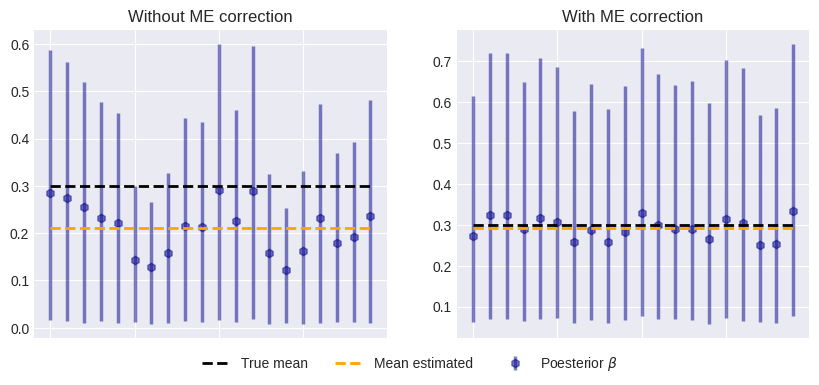

In [18]:
fig, axs = plt.subplots(1,2)
plt.style.use('seaborn-v0_8-darkgrid')
# fig.suptitle(r'Estimated posterior distributions for $\beta$')
plot_simulation_results(res_reduced["b3_naive"], 0.3, axs[0], title="Without ME correction")
plot_simulation_results(res_reduced["b3_corrected"], 0.3, axs[1], title="With ME correction")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=3)
plt.gcf().set_size_inches(10, 4)
plt.savefig("plots/simulation_posterior_b3.pdf")

### Posterior plots for $\beta=0.6$

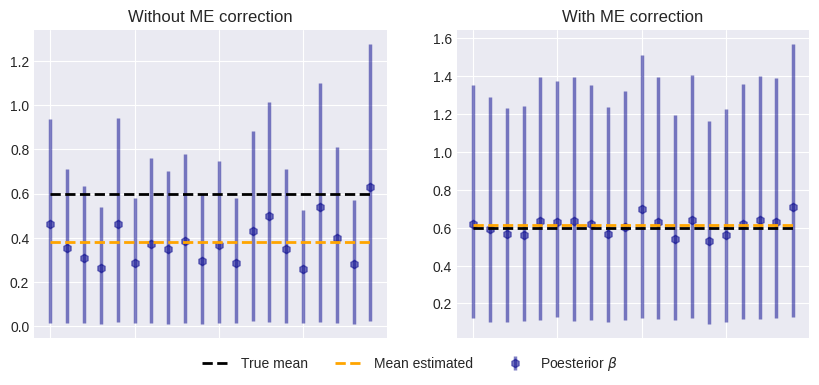

In [8]:
fig, axs = plt.subplots(1,2)
# fig.suptitle(r'Estimated posterior distributions for $\beta$')
plot_simulation_results(res_reduced["b6_naive"], 0.6, axs[0], title="Without ME correction")
plot_simulation_results(res_reduced["b6_corrected"], 0.6, axs[1], title="With ME correction")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=3)
plt.gcf().set_size_inches(10, 4)
plt.savefig("plots/simulation_posterior_b6.pdf")

### Posterior plots for Misspecification settings and $\beta=0.3$

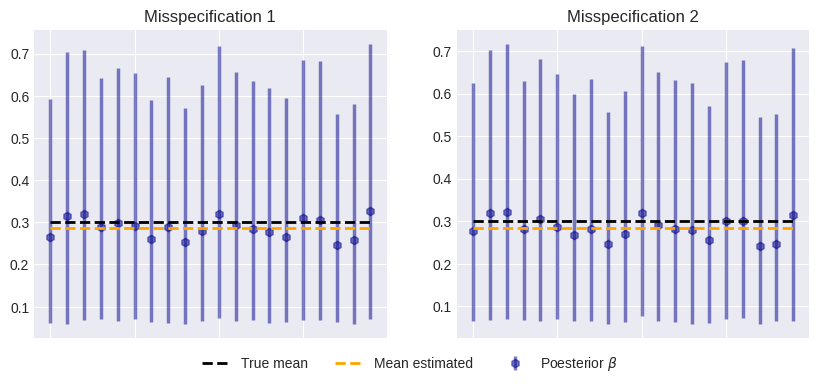

In [9]:
fig, axs = plt.subplots(1,2)
# fig.suptitle(r'Estimated posterior distributions for $\beta$')
plot_simulation_results(res_reduced["misspec1"], 0.3, axs[0], title="Misspecification 1")
plot_simulation_results(res_reduced["misspec2"], 0.3, axs[1], title="Misspecification 2")
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncols=3)
plt.gcf().set_size_inches(10, 4)
plt.savefig("plots/simulation_posterior_misspec.pdf")

### Further analysis as tables

#### Absolute bias

In [35]:
mean_ests = valmap(lambda d: np.array([d[i]["mean"] for i in d]), res_reduced)


abs_biases = dict(
    bias_b3_naive = mean_ests["b3_naive"]-0.3,
    bias_b3_corrected = mean_ests["b3_corrected"]-0.3,
    bias_b6_naive = mean_ests["b6_naive"]-0.6,
    bias_b6_corrected = mean_ests["b6_corrected"]-0.6,
    bias_b3_misspec1 = mean_ests["misspec1"]-0.3,
    bias_b3_misspec2 = mean_ests["misspec2"]-0.3
)


def calc_bias_summary(biases):
    biases = biases[~np.isnan(biases)]
    mean_abs_biases = biases.mean()
    n = biases.__len__()
    mc_sd = np.sqrt((n*(n-1))**-1 * np.sum((biases-mean_abs_biases)**2)) # formula from morris2019
    return dict(mean_biases = mean_abs_biases, mc_sd = mc_sd)
    

# calc mean abs biases
abs_biases_summary = valmap(calc_bias_summary, abs_biases)

In [42]:
abs_biases_summary

{'bias_b3_naive': {'mean_biases': -0.07975857283835179,
  'mc_sd': 0.005391860130703524},
 'bias_b3_corrected': {'mean_biases': 0.0040707507895383355,
  'mc_sd': 0.0031922282858076402},
 'bias_b6_naive': {'mean_biases': -0.20652045452974097,
  'mc_sd': 0.01026551606598824},
 'bias_b6_corrected': {'mean_biases': 0.022377131871579543,
  'mc_sd': 0.005676777558663674},
 'bias_b3_misspec1': {'mean_biases': -0.002081810783579113,
  'mc_sd': 0.003048576282997079},
 'bias_b3_misspec2': {'mean_biases': -0.004047869821493366,
  'mc_sd': 0.0029951097874710265}}

#### Realtive bias

In [36]:
rel_biases = dict(
    bias_b3_naive = mean_ests["b3_naive"]/0.3 -1,
    bias_b3_corrected = mean_ests["b3_corrected"]/0.3-1,
    bias_b6_naive = mean_ests["b6_naive"]/0.6-1,
    bias_b6_corrected = mean_ests["b6_corrected"]/0.6-1,
    bias_b3_misspec1 = mean_ests["misspec1"]/0.3-1,
    bias_b3_misspec2 = mean_ests["misspec2"]/0.3-1
)

# calc mean rel biases
rel_biases_summary = valmap(calc_bias_summary, rel_biases)

#### MSE

In [53]:
def calc_MSE_summary(x, true_x):
    x = x[~np.isnan(x)]
    n = x.__len__()
    mse = np.mean((x-true_x)**2)
    mc_error = np.sqrt( (n*(n-1))**-1 * np.sum( (((x-true_x)**2)-mse)**2 ))
    return dict(mse = mse, mc_sd = mc_error)
                       


mses_summary = dict(
    mse_b3_naive = calc_MSE_summary(mean_ests["b3_naive"], 0.3),
    mse_b3_corrected = calc_MSE_summary(mean_ests["b3_corrected"], 0.3),
    mse_b6_naive = calc_MSE_summary(mean_ests["b6_naive"], 0.6),
    mse_b6_corrected = calc_MSE_summary(mean_ests["b6_corrected"], 0.6),
    mse_b3_misspec1 = calc_MSE_summary(mean_ests["misspec1"], 0.3),
    mse_b3_misspec2 = calc_MSE_summary(mean_ests["misspec2"],0.3)
)


#### Coverage

In [12]:
def calc_coverage_summary(hdi_list, true_value):
    hdi_list = [el for el in hdi_list if el is not None]
    hdis = np.vstack(hdi_list)
    inside = np.apply_along_axis(lambda hdi: True if (true_value > hdi[0]) & (true_value < hdi[1]) else False, 1, hdis)
    coverage = np.mean(inside)
    mc_sd = np.sqrt(coverage*(1-coverage)/coverage.size)
    return dict(coverage = coverage, mc_sd = mc_sd)
    

In [13]:
hdi_ests = valmap(lambda d: [d[i]["hdi"] for i in d], res_reduced)

hdi_coverage_summary = dict(
    hdi_b3_naive = calc_coverage_summary(hdi_ests["b3_naive"], 0.3),
    hdi_b3_corrected = calc_coverage_summary(hdi_ests["b3_corrected"],0.3),
    hdi_b6_naive = calc_coverage_summary(hdi_ests["b6_naive"], 0.6),
    hdi_b6_corrected = calc_coverage_summary(hdi_ests["b6_corrected"], 0.6),
    hdi_b3_misspec1 = calc_coverage_summary(hdi_ests["misspec1"],0.3),
    hdi_b3_misspec2 = calc_coverage_summary(hdi_ests["misspec2"],0.3)
)



In [61]:
print("Results absolute bias")
pprint.pprint(ac.dict_map(lambda x: round(x, 3), abs_biases_summary))

print("Results relative bias")
pprint.pprint(ac.dict_map(lambda x: round(x, 3), rel_biases_summary))

print("Results MSE")
pprint.pprint(ac.dict_map(lambda x: round(x, 4), mses_summary))

print("Results coverage")
pprint.pprint(ac.dict_map(lambda x: round(x, 3), hdi_coverage_summary))

Results absolute bias
{'bias_b3_corrected': {'mc_sd': 0.003, 'mean_biases': 0.004},
 'bias_b3_misspec1': {'mc_sd': 0.003, 'mean_biases': -0.002},
 'bias_b3_misspec2': {'mc_sd': 0.003, 'mean_biases': -0.004},
 'bias_b3_naive': {'mc_sd': 0.005, 'mean_biases': -0.08},
 'bias_b6_corrected': {'mc_sd': 0.006, 'mean_biases': 0.022},
 'bias_b6_naive': {'mc_sd': 0.01, 'mean_biases': -0.207}}
Results relative bias
{'bias_b3_corrected': {'mc_sd': 0.011, 'mean_biases': 0.014},
 'bias_b3_misspec1': {'mc_sd': 0.01, 'mean_biases': -0.007},
 'bias_b3_misspec2': {'mc_sd': 0.01, 'mean_biases': -0.013},
 'bias_b3_naive': {'mc_sd': 0.018, 'mean_biases': -0.266},
 'bias_b6_corrected': {'mc_sd': 0.009, 'mean_biases': 0.037},
 'bias_b6_naive': {'mc_sd': 0.017, 'mean_biases': -0.344}}
Results MSE
{'mse_b3_corrected': {'mc_sd': 0.0001, 'mse': 0.001},
 'mse_b3_misspec1': {'mc_sd': 0.0001, 'mse': 0.0009},
 'mse_b3_misspec2': {'mc_sd': 0.0001, 'mse': 0.0009},
 'mse_b3_naive': {'mc_sd': 0.001, 'mse': 0.0092},
 'ms

### Convergence diagnostics

In [15]:
rhats = valmap(lambda s: np.concatenate([x.to_array().to_numpy() for x in ac.calc_rhat(s, (1,len(s)+1), simplify=True)]), samples)

arviz - WARNING - Shape validation failed: input_shape: (1, 0), minimum_shape: (chains=2, draws=4)


In [16]:
def make_hist_rhats(rhats, axs, title):
    n, bins, patches = axs.hist(rhats, bins=40, facecolor='darkblue', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.5)
    axs.set_title(title)
    
    info = map(lambda patch: patch.get_xy()[0] > 1.05, patches)
    pos = [i for i, tr in enumerate(info) if tr]
    
    for i in pos:
        patches[i].set_fc('red')
    
    

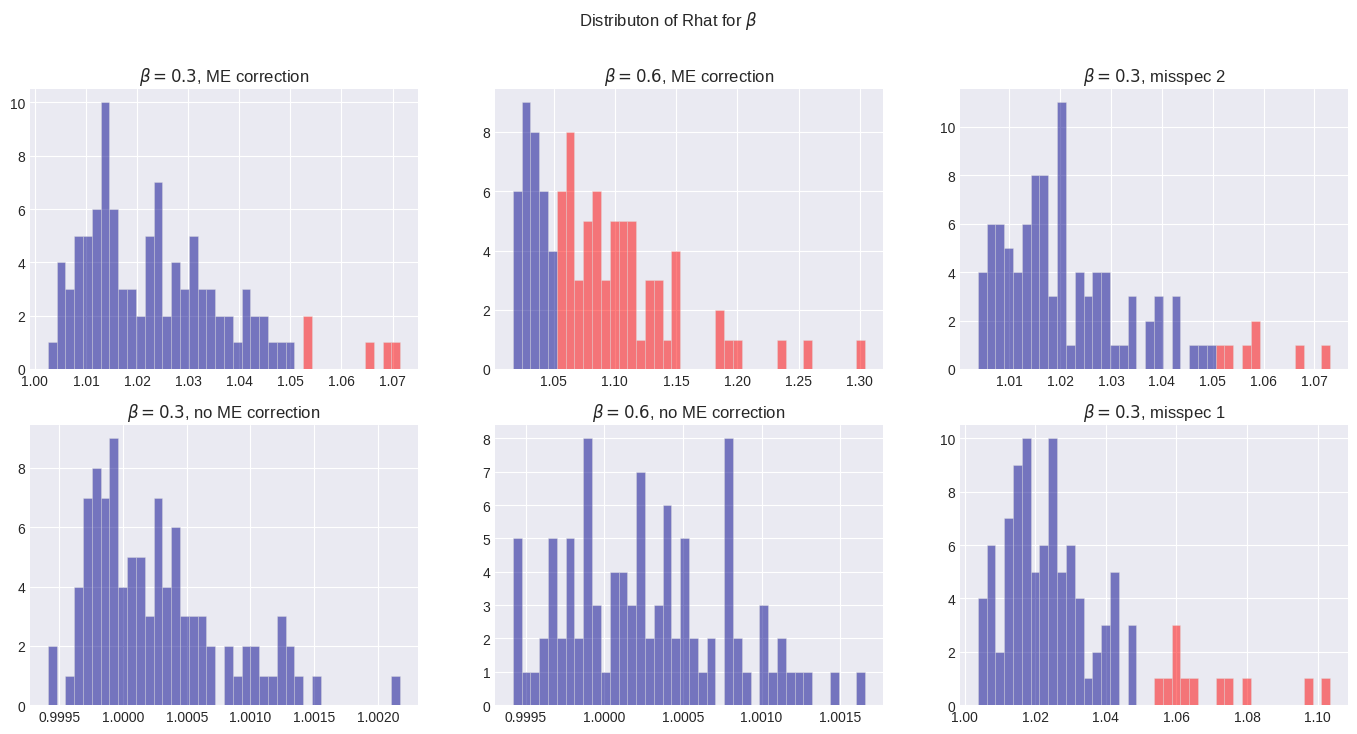

In [17]:
fig, axs = plt.subplots(2,3)
plt.style.use('seaborn-v0_8-darkgrid')

fig.suptitle(r'Distributon of Rhat for $\beta$')



make_hist_rhats(rhats['b3_corrected'], axs[0,0], r'$\beta=0.3$, ME correction')
make_hist_rhats(rhats['b3_naive'], axs[1,0], r'$\beta=0.3$, no ME correction')


make_hist_rhats(rhats['b6_corrected'], axs[0,1], r'$\beta=0.6$, ME correction')
make_hist_rhats(rhats['b6_naive'], axs[1,1], r'$\beta=0.6$, no ME correction')


make_hist_rhats(rhats['misspec2'], axs[0,2], r'$\beta=0.3$, misspec 2')
make_hist_rhats(rhats['misspec1'], axs[1,2], r'$\beta=0.3$, misspec 1')


# handles, labels = axs[0].get_legend_handles_labels()
# fig.legend(handles, labels, loc='lower center', ncols=3)
plt.gcf().set_size_inches(17, 8)
plt.savefig("plots/simulation_distribution_rhats.pdf")

<Figure size 640x480 with 0 Axes>

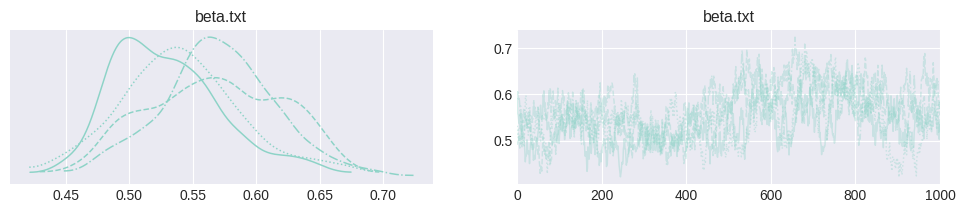

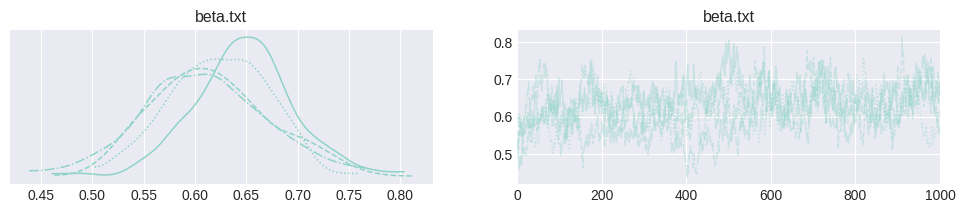

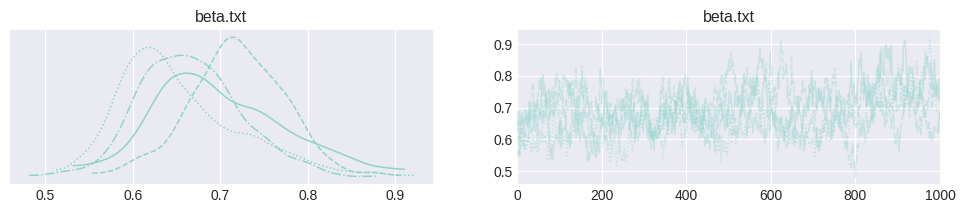

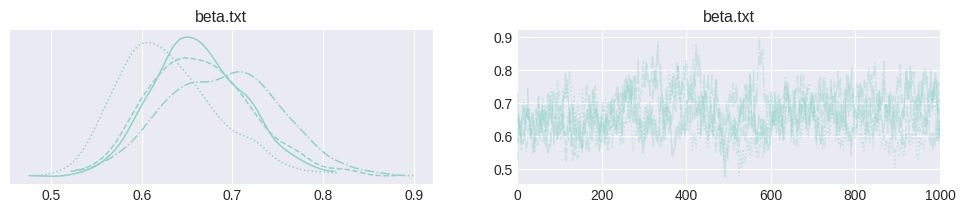

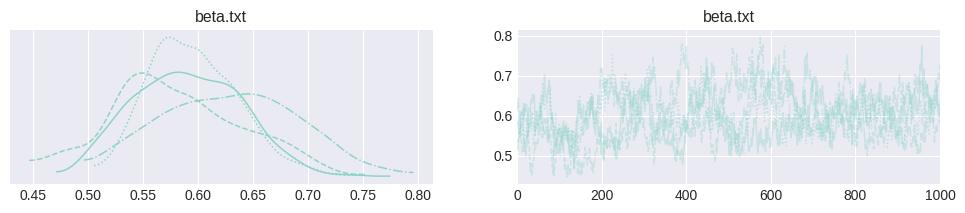

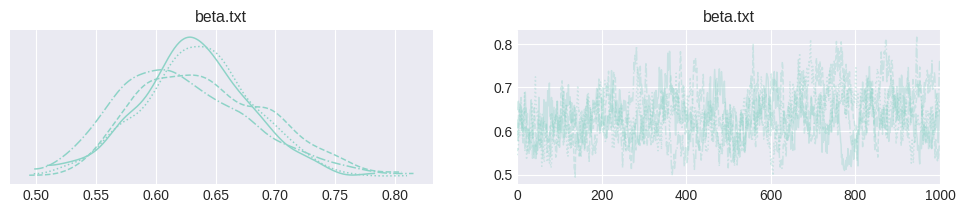

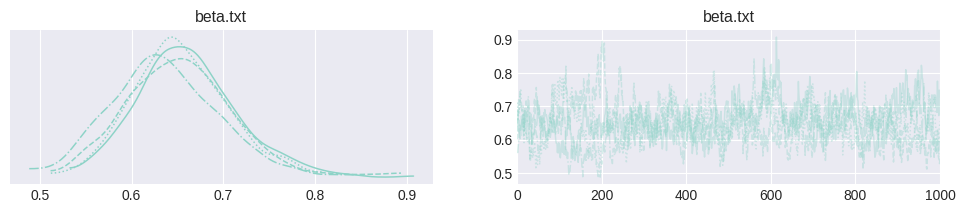

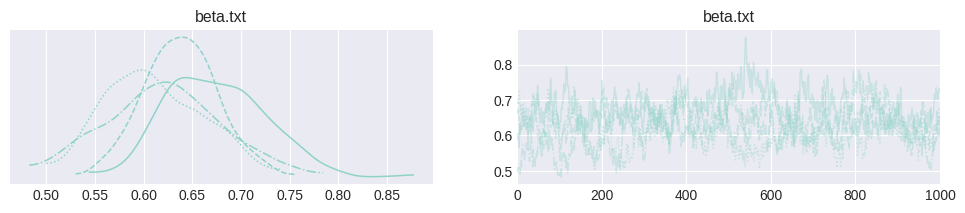

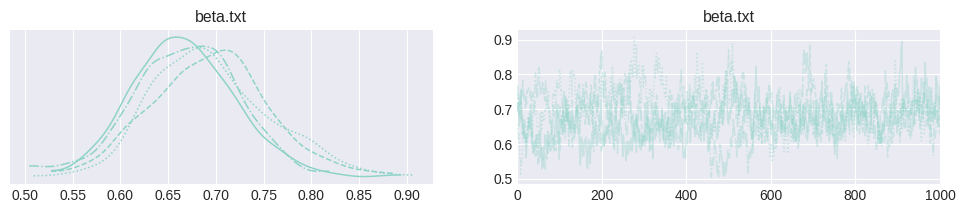

In [186]:
ac.plot_chains_sim(samples["b6_corrected10"], (1,10))